In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Part 1: Generate Movie Analysts

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(description="Affiliation of the analyst.")
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst.")
    description: str = Field(description="Description of the analyst's focus.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="List of analysts with their roles and affiliations.")

class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

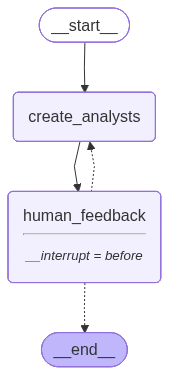

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions = """You are creating movie review analysts. Follow these instructions:

1. Review the movie topic: {topic}
2. Consider any feedback: {human_analyst_feedback}
3. Create {max_analysts} analysts focused on different aspects of movie reviews
4. Each analyst should focus on: Critical Reception, Audience Response, Technical Aspects, or Story/Performance
"""

def create_analysts(state: GenerateAnalystsState):
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')
    
    structured_llm = llm.with_structured_output(Perspectives)
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )
    
    analysts = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate the movie review analysts.")
    ])
    
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    pass

def should_continue(state: GenerateAnalystsState):
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    return END

# Build graph
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Generate analysts for movie review
max_analysts = 2
topic = "Dune: Part Two movie review"
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alice Thompson
Affiliation: Film Critic Association
Role: Film Critic
Description: Alice focuses on the critical reception of 'Dune: Part Two', analyzing reviews from top critics and aggregating scores from platforms like Rotten Tomatoes and Metacritic. She examines how the film's themes, direction, and performances resonate with critics and how they compare to the first installment.
--------------------------------------------------
Name: Mark Johnson
Affiliation: Audience Insights Group
Role: Audience Analyst
Description: Mark specializes in audience response to 'Dune: Part Two', gathering data from social media, audience ratings, and box office performance. He explores how viewers perceive the film's storytelling, character development, and visual effects, and how these elements contribute to overall audience satisfaction.
--------------------------------------------------


In [7]:
# Accept the analysts (no changes needed)
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b72ea-f6ed-6804-8002-b074b16487b3'}}

In [8]:
# Continue and get final analysts
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
print("\nFinal Analysts:")
for analyst in analysts:
    print(f"\n{analyst.name} - {analyst.role}")


Final Analysts:

Alice Thompson - Film Critic

Mark Johnson - Audience Analyst


## Part 2: Conduct Interviews

In [9]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [10]:
question_instructions = """You are a movie analyst interviewing an expert about: {goals}

Your goal is to gather specific insights about the movie:
1. Focus on concrete examples and specific details
2. Ask follow-up questions to get deeper insights
3. When satisfied, end with: "Thank you so much for your help!"

Start by introducing yourself and asking your first question.
"""

def generate_question(state: InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)
    
    return {"messages": [question]}

In [11]:
# Web search tool (simplified - only using Tavily)
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=2)

search_instructions = SystemMessage(content="""Generate a well-structured search query 
for movie information based on the conversation. Focus on the analyst's last question.""")

def search_web(state: InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    search_docs = tavily_search.invoke(search_query.search_query)
    formatted_search_docs = "\n\n---\n\n".join([
        f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
        for doc in search_docs
    ])
    
    return {"context": [formatted_search_docs]}

/var/folders/6d/nrcfk1zj04jb6zj0_p75ydvw0000gn/T/ipykernel_55034/1572635060.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=2)


In [12]:
answer_instructions = """You are a movie expert being interviewed by {goals}.

Answer using this context:
{context}

Guidelines:
1. Use only information from the context
2. Cite sources using [1], [2] format
3. List sources at the end
4. Be specific with examples
"""

def generate_answer(state: InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)
    answer.name = "expert"
    
    return {"messages": [answer]}

from langchain_core.messages import get_buffer_string

def save_interview(state: InterviewState):
    messages = state["messages"]
    interview = get_buffer_string(messages)
    return {"interview": interview}

def route_messages(state: InterviewState, name: str = "expert"):
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)
    
    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])
    
    if num_responses >= max_num_turns:
        return 'save_interview'
    
    last_question = messages[-2]
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

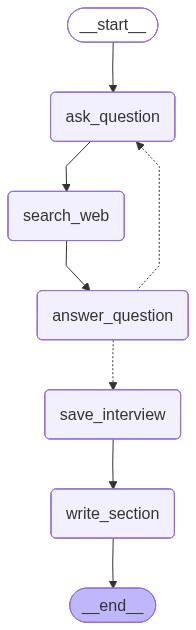

In [13]:
section_writer_instructions = """You are writing a movie review section.

Create a section with:
## {focus}
### Summary (200-300 words)
### Sources

Focus on specific details and examples from the interview.
"""

def write_section(state: InterviewState):
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    
    system_message = section_writer_instructions.format(focus=analyst.role)
    section = llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content=f"Use this context: {context}")
    ])
    
    return {"sections": [section.content]}

# Build interview graph
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ['ask_question', 'save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory)
display(Image(interview_graph.get_graph().draw_mermaid_png()))

## Part 3: Complete Research System

/var/folders/6d/nrcfk1zj04jb6zj0_p75ydvw0000gn/T/ipykernel_55034/2671174223.py:9: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


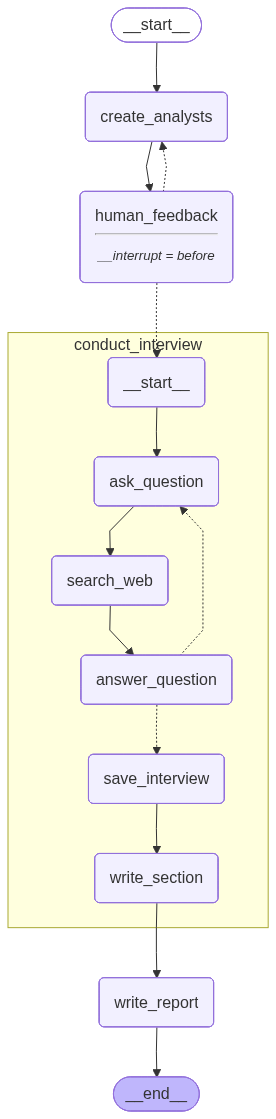

In [14]:
class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    final_report: str

from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"
    
    topic = state["topic"]
    return [Send("conduct_interview", {
        "analyst": analyst,
        "messages": [HumanMessage(content=f"Let's discuss {topic}")]
    }) for analyst in state["analysts"]]

report_writer_instructions = """Write a movie review report combining these sections:

{context}

Create a cohesive review with:
# {topic}
## Critical Reception
## Audience Response  
## Sources

Target 400-500 words total.
"""

def write_report(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]
    
    formatted_sections = "\n\n".join([f"{section}" for section in sections])
    system_message = report_writer_instructions.format(topic=topic, context=formatted_sections)
    report = llm.invoke([SystemMessage(content=system_message), 
                        HumanMessage(content="Write the movie review.")])
    
    return {"final_report": report.content}

# Build final graph
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, 
                             ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("write_report", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
# Run the complete system
max_analysts = 2
topic = "Dune: Part Two movie review"
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, 
                         thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        print("Generated Analysts:")
        for analyst in analysts:
            print(f"- {analyst.name}: {analyst.role}")

Generated Analysts:
- Emily Carter: Critical Reception Analyst
- Michael Thompson: Audience Response Analyst


In [16]:
# Accept analysts and continue
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

for event in graph.stream(None, thread, stream_mode="updates"):
    print(f"Processing: {next(iter(event.keys()))}")

Processing: conduct_interview
Processing: conduct_interview
Processing: write_report


In [17]:
# Display final report
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Dune: Part Two Movie Review

## Critical Reception
"Dune: Part Two," directed by Denis Villeneuve, has emerged as a cinematic spectacle that has captivated audiences while also sparking a range of critical responses. The film is lauded for its breathtaking visuals and exceptional cinematography, which transport viewers into the intricately crafted universe of Frank Herbert's epic saga. Critics have particularly praised the performances of Timothée Chalamet as Paul Atreides and Zendaya as Chani, highlighting their palpable chemistry and emotional depth. The film's sound design has also received accolades, enhancing the immersive experience that Villeneuve is known for.

However, the film is not without its detractors. Some critics have pointed out pacing issues and rushed climaxes, suggesting that the narrative may leave viewers unfamiliar with the source material feeling disengaged. Concerns have also been raised regarding the emotional stakes of the story, with some feeling that it lacks the tension necessary to elevate the drama. Despite these criticisms, many reviewers appreciate the film's complex world-building and philosophical themes, which resonate with a segment of the audience. Overall, "Dune: Part Two" is viewed as a significant cinematic achievement, with many considering it a worthy continuation of the saga initiated in "Dune: Part One." The film's reception reflects a blend of admiration for its artistic merits and a recognition of its narrative shortcomings.

## Audience Response
Audience reactions to "Dune: Part Two" have been overwhelmingly positive, with a remarkable 92% approval rating on Rotten Tomatoes and an average score of 8.4/10. Viewers have celebrated the film as a visual masterpiece, praising its stunning effects and strong performances, particularly the dynamic between Paul and Chani. Villeneuve himself emphasized the importance of this relationship, stating that it serves as the emotional core of the film amidst the political turmoil.

However, audience feedback has also revealed a mix of admiration and critique. Some viewers expressed disappointment regarding character development and narrative depth, noting that the villains felt underwhelming and lacked a genuine threat. Others criticized the rapid character changes, particularly in the arcs of Jessica and Paul. Despite these critiques, the film received an "A" grade from CinemaScore and a 94% positive score from PostTrak, indicating that a substantial majority of viewers would recommend it. The exploration of themes such as power, prophecy, and personal sacrifice resonated with many, although some felt that the adaptation strayed too far from the source material. Overall, "Dune: Part Two" has sparked engaging discussions about its narrative choices and character arcs, solidifying its place as a significant entry in the science fiction genre.

## Sources
1. [IMDb - Dune: Part Two](https://www.imdb.com/title/tt15239678/)
2. [Rotten Tomatoes - Dune: Part Two Reviews](https://www.rottentomatoes.com/m/dune_part_two/reviews)
3. [Wikipedia - Dune: Part Two](https://en.wikipedia.org/wiki/Dune:_Part_Two)
4. [Screen Daily - Denis Villeneuve Breaks Down Four Key Scenes from Dune: Part Two](https://www.screendaily.com/)
5. [EN World - Review Critical of Dune: Part Two Based on the Depiction of Chani](https://www.enworld.org/) 

In conclusion, "Dune: Part Two" stands as a visually stunning and ambitious continuation of Herbert's saga, inviting both admiration and critique from its audience. Its ability to provoke discussion about its narrative choices and character arcs ensures its place in the annals of science fiction cinema.